# Import data

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

train_features = pd.read_csv('training_set_features.csv')
train_labels = pd.read_csv('training_set_labels.csv')
test_features = pd.read_csv('test_set_features.csv')


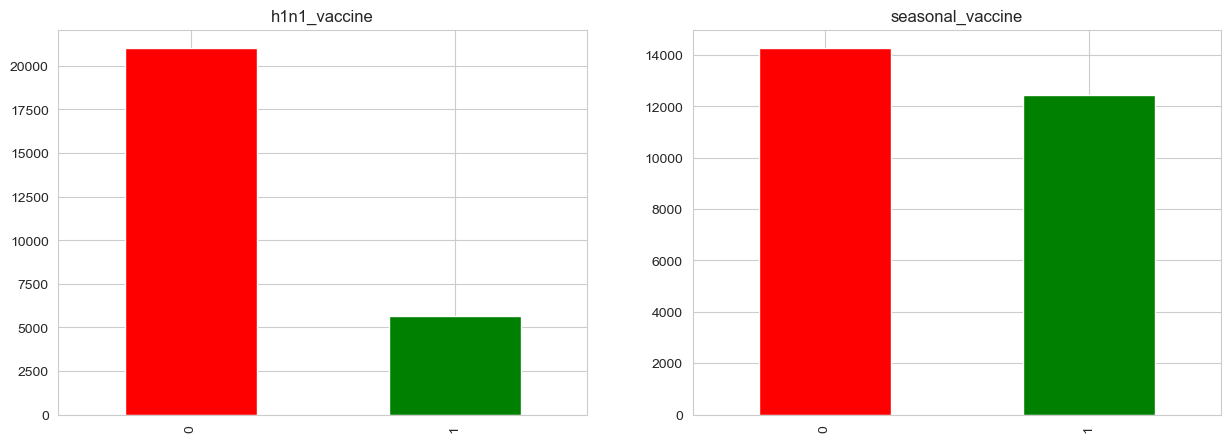

In [2]:
# 画出train_labels中两个label的分布图，这两个分布图最为两个子图，可以看出两个label的分布不均衡
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# 用不同的颜色表示每个label的值，用value_counts()函数统计每个label的值的个数，再用plot()函数画出柱状图
train_labels['h1n1_vaccine'].value_counts().plot(kind='bar', ax=axes[0], title='h1n1_vaccine', color=['red', 'green'])
train_labels['seasonal_vaccine'].value_counts().plot(kind='bar', ax=axes[1], title='seasonal_vaccine', color=['red', 'green'])
plt.show()

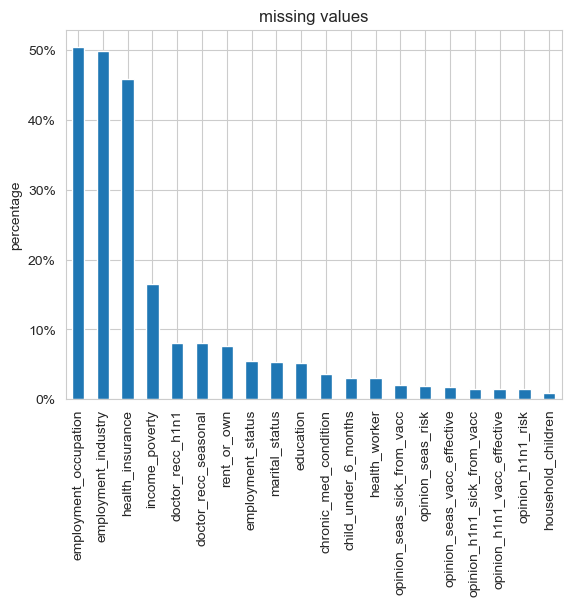

In [3]:
import matplotlib.ticker as mtick
# count missing values
df_missing_values_percentage =train_features.isnull().sum().sort_values(ascending=False)[:20]/len(train_features)
# draw missing values percentage bar chart
df_missing_values_percentage.plot(kind='bar')
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.title('missing values')
plt.ylabel('percentage')
plt.show()

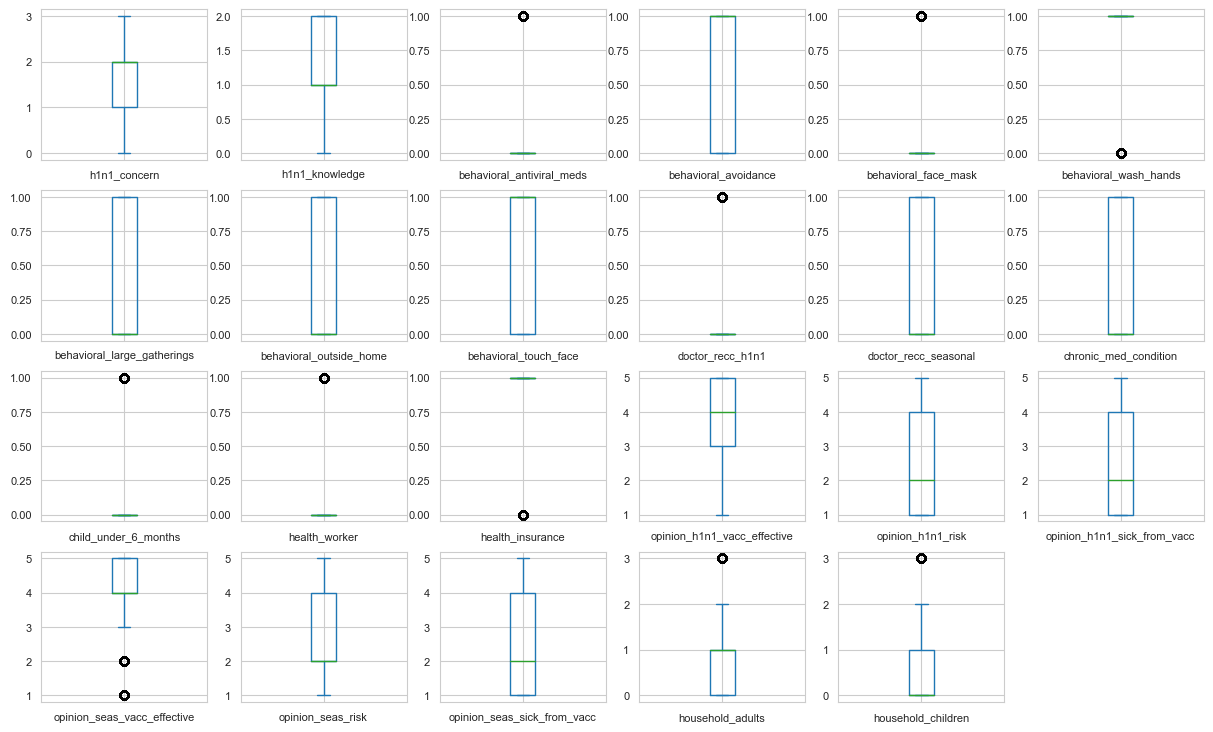

In [4]:
# draw 数值型特征的箱线图，排除respondent_id
numerical_columns = train_features.select_dtypes(include=['int64', 'float64']).columns.drop('respondent_id')
train_features[numerical_columns].plot(kind='box', subplots=True, layout=(4, 6), figsize=(15, 9), fontsize=8)
plt.show()

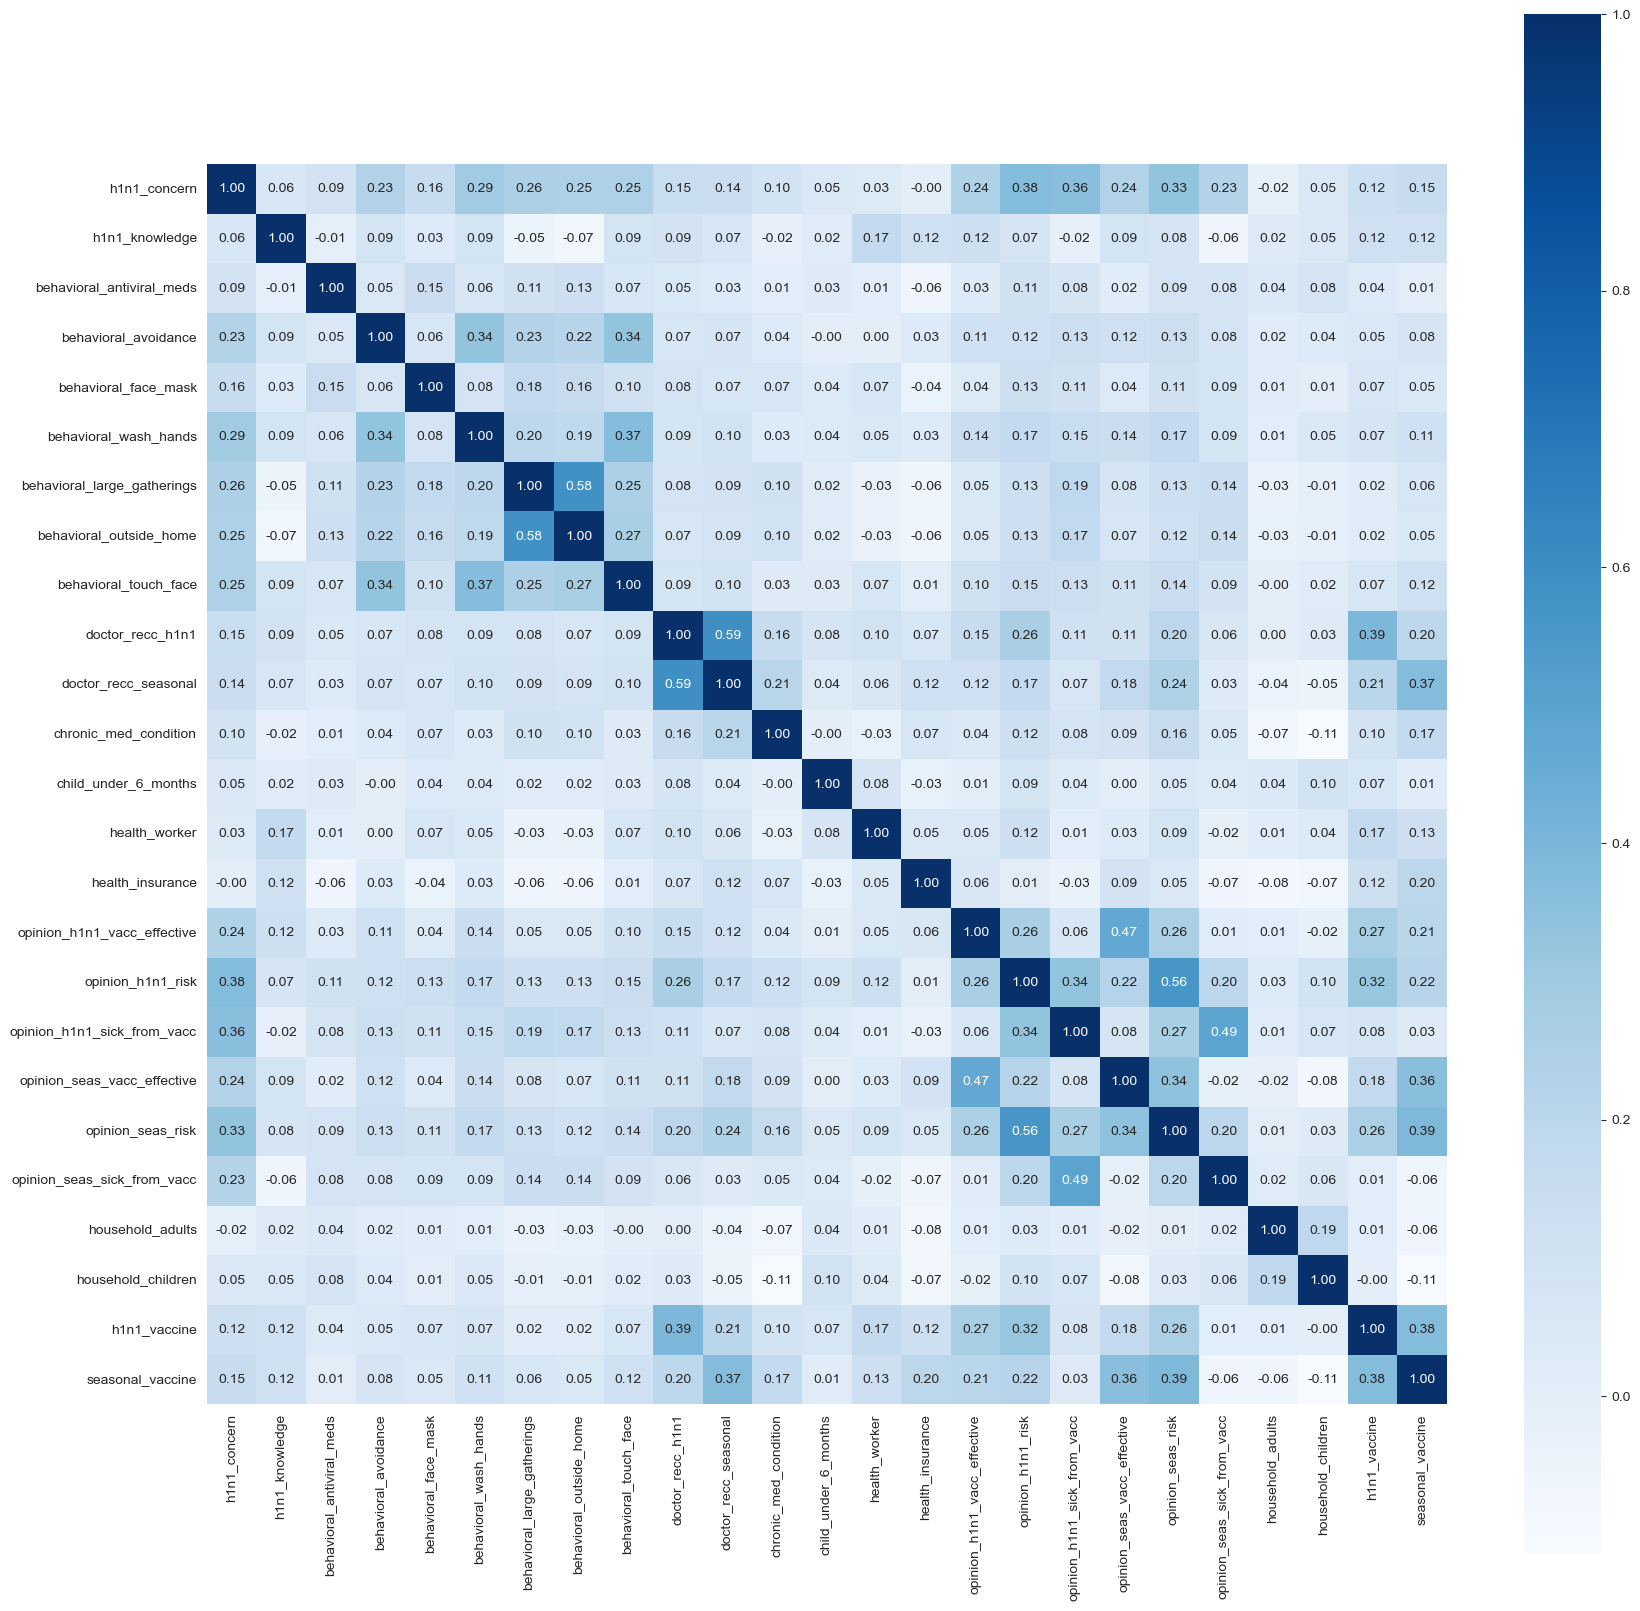

In [5]:
# 画出特征热图包括label中的两个特征，用红蓝色表示正负相关，只显示下三角
import seaborn as sns
heatmap_data = pd.concat([train_features, train_labels], axis=1).drop('respondent_id', axis=1)
plt.figure(figsize=(20, 20))
sns.heatmap(heatmap_data.corr(), annot=True, fmt='.2f', square=True, cmap='Blues')
plt.show()

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Encode categorical variables
le = LabelEncoder()
feature_inportance = train_features.copy()
for column in feature_inportance.columns:
    if feature_inportance[column].dtype == 'object':
        feature_inportance[column] = feature_inportance[column].astype(str)
        feature_inportance[column] = le.fit_transform(feature_inportance[column])

# Impute missing values with the mean for numerical columns
num_imputer = SimpleImputer(strategy='mean')
numerical_columns = feature_inportance.select_dtypes(include=['int64', 'float64']).columns
feature_inportance[numerical_columns] = num_imputer.fit_transform(feature_inportance[numerical_columns])

# Function to calculate feature importances for a given target variable
def calculate_feature_importances(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    importances = rf.feature_importances_
    return pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Calculate feature importances for both target variables
importances_h1n1 = calculate_feature_importances(feature_inportance, train_labels['h1n1_vaccine'])
importances_seasonal = calculate_feature_importances(feature_inportance, train_labels['seasonal_vaccine'])

print("Feature importances for h1n1_vaccine:")
print(importances_h1n1)
print("Feature importances for seasonal_vaccine:")
print(importances_seasonal)

# Set a threshold for feature importance (you can adjust this value based on your specific problem)
threshold = 0.01

# Identify unimportant features
unimportant_features_h1n1 = importances_h1n1[importances_h1n1 < threshold].index
unimportant_features_seasonal = importances_seasonal[importances_seasonal < threshold].index
print("Unimportant features for h1n1_vaccine:")
print(unimportant_features_h1n1)
print("Unimportant features for seasonal_vaccine:")
print(unimportant_features_seasonal)

# Check if 'employment_industry', 'employment_occupation', and 'health_insurance' are unimportant
features_to_check = ['employment_industry', 'employment_occupation', 'health_insurance']
unimportant_checked_features_h1n1 = [feature for feature in features_to_check if feature in unimportant_features_h1n1]
unimportant_checked_features_seasonal = [feature for feature in features_to_check if feature in unimportant_features_seasonal]

if unimportant_checked_features_h1n1:
    print("Unimportant checked features for h1n1_vaccine:")
    print(unimportant_checked_features_h1n1)
else:
    print("All checked features are important for h1n1_vaccine.")

if unimportant_checked_features_seasonal:
    print("Unimportant checked features for seasonal_vaccine:")
    print(unimportant_checked_features_seasonal)
else:
    print("All checked features are important for seasonal_vaccine.")

Feature importances for h1n1_vaccine:
doctor_recc_h1n1               0.101279
respondent_id                  0.078692
opinion_h1n1_risk              0.069636
health_insurance               0.061872
opinion_h1n1_vacc_effective    0.055302
hhs_geo_region                 0.046420
opinion_seas_risk              0.040587
employment_occupation          0.038484
employment_industry            0.034149
age_group                      0.032126
opinion_h1n1_sick_from_vacc    0.027188
opinion_seas_vacc_effective    0.026801
h1n1_concern                   0.026715
education                      0.025987
opinion_seas_sick_from_vacc    0.024791
doctor_recc_seasonal           0.023216
census_msa                     0.022720
income_poverty                 0.022246
household_adults               0.021946
h1n1_knowledge                 0.020571
household_children             0.018375
health_worker                  0.016440
race                           0.016323
sex                            0.013946
ma

# Data preprocessing

In [7]:
def preprocess_data(features, is_train=True, encoders=None):
    # 如果数据集中包含respondent_id，删除该特征
    if 'respondent_id' in features.columns:
        features.drop(['respondent_id'], axis=1, inplace=False)

    # 处理缺失值
    features.fillna({'health_insurance': 0, 'child_under_6_months': 0}, inplace=True)
    features.fillna(features.mean(), inplace=True)
    features.fillna('unknown', inplace=True)

    # 处理离群值
    numerical_columns = features.select_dtypes(include=['int64', 'float64']).columns
    for column in numerical_columns:
        Q1 = features[column].quantile(0.25)
        Q3 = features[column].quantile(0.75)
        IQR = Q3 - Q1
        features[column] = np.where(features[column] < (Q1 - 1.5 * IQR), Q1 - 1.5 * IQR, features[column])
        features[column] = np.where(features[column] > (Q3 + 1.5 * IQR), Q3 + 1.5 * IQR, features[column])

    # 标签编码
    label_columns = [
        'age_group',
        'education',
        'income_poverty',
        'h1n1_concern',
        'h1n1_knowledge',
        'opinion_h1n1_vacc_effective',
        'opinion_h1n1_risk',
        'opinion_h1n1_sick_from_vacc',
        'opinion_seas_vacc_effective',
        'opinion_seas_risk',
        'opinion_seas_sick_from_vacc',
    ]

    # 独热编码
    one_hot_columns = [
        'race',
        'sex',
        'marital_status',
        'rent_or_own',
        'employment_status',
        'hhs_geo_region',
        'census_msa',
        'employment_industry',
        'employment_occupation',
    ]

    if is_train:
        encoders = {}

        for column in label_columns:
            le = LabelEncoder()
            unique_values = features[column].unique().tolist()
            unique_values.append('unknown')
            le.fit(unique_values)
            features[column] = le.transform(features[column])
            encoders[column] = le

        ohe = OneHotEncoder(sparse=False)
        one_hot_encoded = ohe.fit_transform(features[one_hot_columns])
        encoders['one_hot'] = ohe
        features = features.drop(one_hot_columns, axis=1)
        features = pd.concat([features, pd.DataFrame(one_hot_encoded, columns=ohe.get_feature_names_out(one_hot_columns))], axis=1)
    else:
        for column in label_columns:
            features[column] = features[column].apply(lambda x: x if x in encoders[column].classes_ else 'unknown')
            features[column] = encoders[column].transform(features[column])

        one_hot_encoded = encoders['one_hot'].transform(features[one_hot_columns])
        features = features.drop(one_hot_columns, axis=1)
        features = pd.concat([features, pd.DataFrame(one_hot_encoded, columns=encoders['one_hot'].get_feature_names_out(one_hot_columns))], axis=1)

    # 标准化数据
    numerical_columns = features.select_dtypes(include=['int64', 'float64']).columns
    if is_train:
        scaler = StandardScaler()
        features[numerical_columns] = scaler.fit_transform(features[numerical_columns])
        encoders['scaler'] = scaler
    else:
        features[numerical_columns] = encoders['scaler'].transform(features[numerical_columns])

    return features, encoders

In [8]:
# deal with data Imbalance method: SMOTE
from imblearn.over_sampling import SMOTE

def deal_with_imbalance(X, y):
    smote = SMOTE(random_state=42)
    X, y = smote.fit_resample(X, y)
    return X, y

# Construct neural network structure

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

class PyTorchMLPClassifier:
    def __init__(self, hidden_size=64, output_size=1, batch_size=64, learning_rate=0.0001, num_epochs=20,
                 lr_decay_step_size=1, lr_decay_gamma=0.9, dropout_rate=0.2, random_state=None):
        self.input_size = None
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.dropout_rate = dropout_rate
        self.random_state = random_state

        self.model = None
        self.criterion = nn.BCELoss()
        self.optimizer = None
        self.scheduler = None

        self.train_loss_history = []
        self.valid_loss_history = []
        self.lr_history = []

    class Net(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super().__init__()
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(hidden_size, output_size)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            out = self.fc1(x)
            out = self.relu(out)
            out = self.fc2(out)
            out = self.sigmoid(out)
            return out

    def fit(self, X, y, X_valid=None, y_valid=None):
        # Set input_size based on X's number of features
        self.input_size = X.shape[1]

        # Create model, optimizer and scheduler after input_size is determined
        self.model = self.Net(self.input_size, self.hidden_size, self.output_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=self.num_epochs, eta_min=self.learning_rate/100)

        X_train_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32)
        y_train_tensor = torch.tensor(y.to_numpy(), dtype=torch.float32).unsqueeze(1)  # Add extra dimension
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.num_epochs):
            self.model.train()
            train_loss = 0

            for batch_x, batch_y in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(batch_x)
                loss = self.criterion(outputs, batch_y)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()

            # Record learning rate
            self.lr_history.append(self.scheduler.get_last_lr()[0])

            # Record train loss
            self.train_loss_history.append(train_loss / len(train_loader))

            # If validation data is provided, compute and record validation loss
            if X_valid is not None and y_valid is not None:
                self.model.eval()
                with torch.no_grad():
                    X_valid_tensor = torch.tensor(X_valid.to_numpy(), dtype=torch.float32)
                    y_valid_tensor = torch.tensor(y_valid.to_numpy(), dtype=torch.float32).unsqueeze(1)
                    outputs = self.model(X_valid_tensor)
                    valid_loss = self.criterion(outputs, y_valid_tensor)
                self.valid_loss_history.append(valid_loss.item())

            self.scheduler.step()


    def predict_proba(self, X):
        X_test_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32)
        self.model.eval()

        with torch.no_grad():
            outputs = self.model(X_test_tensor)
        proba = outputs.numpy()
        return np.hstack([1 - proba, proba])


    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)


    def score(self, X, y):
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y)
        return accuracy

    def get_params(self, deep=True):
        # Suppose this estimator has parameters "alpha" and "recursive"
        return {"hidden_size": self.hidden_size, "output_size": self.output_size, "learning_rate": self.learning_rate, "num_epochs": self.num_epochs}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    import matplotlib.pyplot as plt

    def plot_lr_history(clf):
        plt.plot(clf.lr_history)
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate History')
        plt.show()

    def plot_loss_history(clf):
        plt.plot(clf.train_loss_history, label='Train')
        if clf.valid_loss_history:
            plt.plot(clf.valid_loss_history, label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss History')
        plt.legend()
        plt.show()

/var/folders/n_/54212b493pd645vds1j7659c0000gn/T/ipykernel_99698/156986860.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  features.fillna(features.mean(), inplace=True)
/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


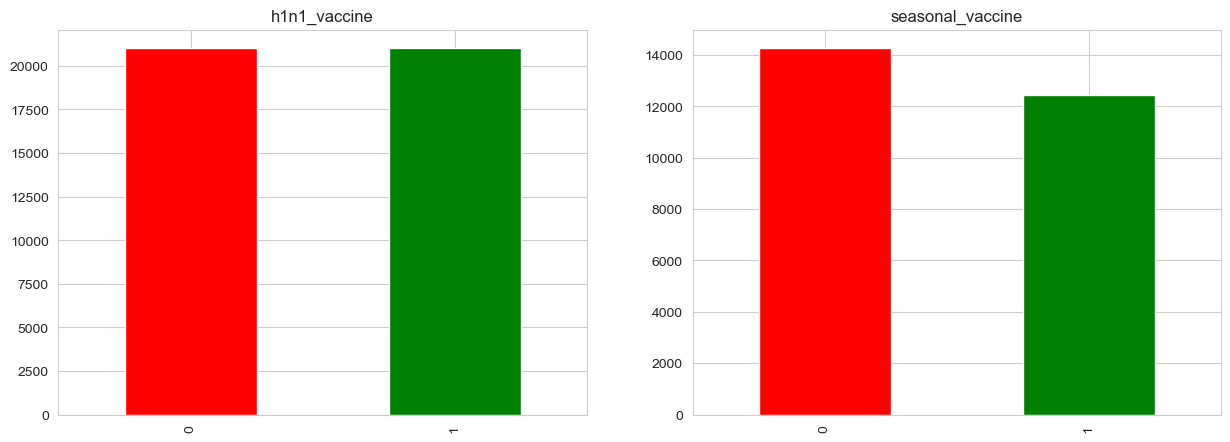

In [10]:
# 数据预处理
X_f, encoders = preprocess_data(train_features)
y_table_h1n1 = train_labels['h1n1_vaccine']
y_table_seasonal = train_labels['seasonal_vaccine']

# 处理h1n1疫苗标签的数据不平衡问题
X_f_h1n1_smote, y_table_h1n1_smote = deal_with_imbalance(X_f, y_table_h1n1)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# 用不同的颜色表示每个label的值，用value_counts()函数统计每个label的值的个数，再用plot()函数画出柱状图
y_table_h1n1_smote.value_counts().plot(kind='bar', ax=axes[0], title='h1n1_vaccine', color=['red', 'green'])
y_table_seasonal.value_counts().plot(kind='bar', ax=axes[1], title='seasonal_vaccine', color=['red', 'green'])
plt.show()

In [11]:
# 划分训练集和验证集
X_train_h1n1, X_val_h1n1, y_train_h1n1, y_val_h1n1 = train_test_split(X_f_h1n1_smote, y_table_h1n1_smote, test_size=0.2, random_state=42)
X_train_seasonal, X_val_seasonal, y_train_seasonal, y_val_seasonal = train_test_split(X_f, y_table_seasonal, test_size=0.2, random_state=42)

model_h1n1 = PyTorchMLPClassifier()
model_seasonal = PyTorchMLPClassifier()

# 分别训练两个模型
model_h1n1.fit(X_train_h1n1, y_train_h1n1, X_val_h1n1, y_val_h1n1)
model_seasonal.fit(X_train_seasonal, y_train_seasonal, X_val_seasonal,y_val_seasonal)

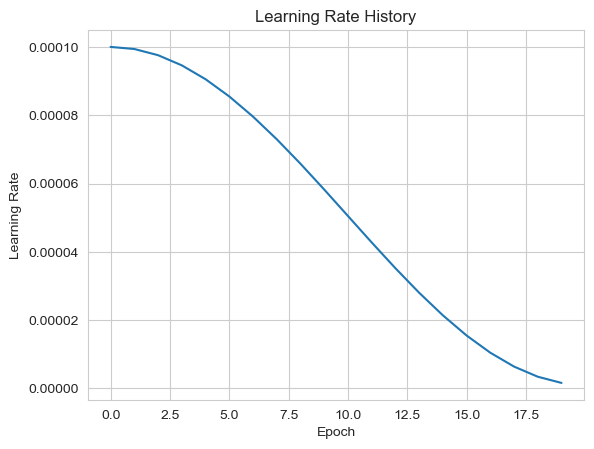

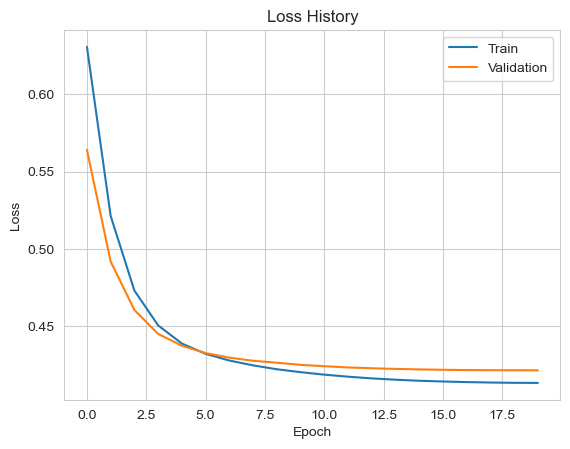

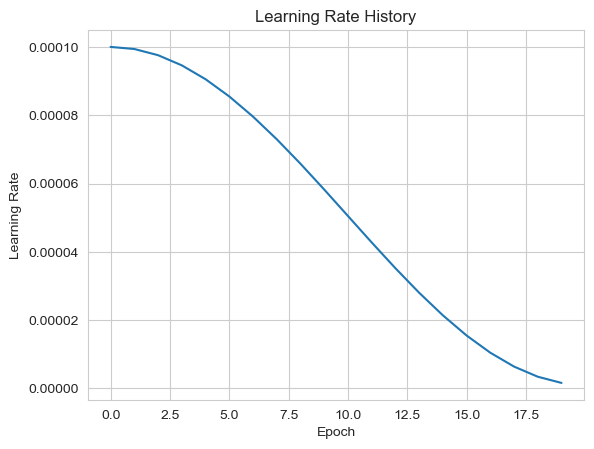

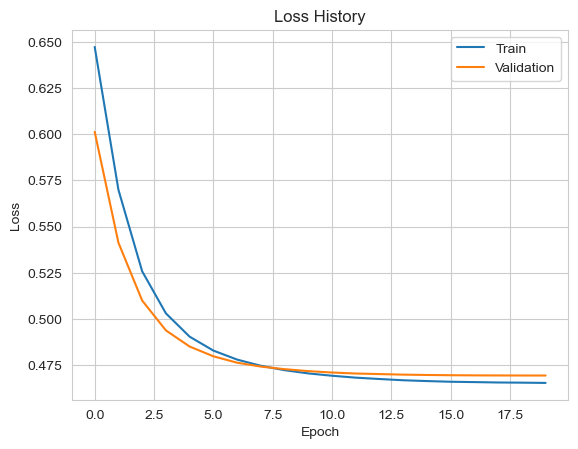

In [12]:
model_h1n1.plot_lr_history()
model_h1n1.plot_loss_history()
model_seasonal.plot_lr_history()
model_seasonal.plot_loss_history()

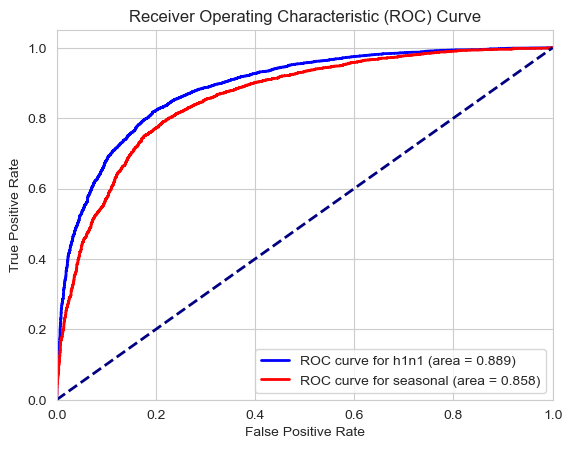

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities
y_prob_h1n1 = model_h1n1.predict_proba(X_val_h1n1)[:,1]
y_prob_seasonal = model_seasonal.predict_proba(X_val_seasonal)[:,1]

# Compute ROC curve and ROC area for each target
fpr_h1n1, tpr_h1n1, _ = roc_curve(y_val_h1n1, y_prob_h1n1)
roc_auc_h1n1 = auc(fpr_h1n1, tpr_h1n1)

fpr_seasonal, tpr_seasonal, _ = roc_curve(y_val_seasonal, y_prob_seasonal)
roc_auc_seasonal = auc(fpr_seasonal, tpr_seasonal)

# Plot ROC curve for h1n1
plt.plot(fpr_h1n1, tpr_h1n1, color='b', lw=2, label=f'ROC curve for h1n1 (area = {roc_auc_h1n1:.3f})')

# Plot ROC curve for seasonal
plt.plot(fpr_seasonal, tpr_seasonal, color='r', lw=2, label=f'ROC curve for seasonal (area = {roc_auc_seasonal:.3f})')

# Plot settings
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Ablation experiment

In [14]:
from sklearn.base import clone

def train_and_evaluate_model(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    probabilities = model.predict_proba(X_val)[:, 1]
    preds = model.predict(X_val)
    fpr, tpr, _ = roc_curve(y_val, probabilities)
    roc_auc = auc(fpr, tpr)
    return roc_auc, preds, fpr, tpr


def plot_roc_curves(ax, fpr_h1n1, tpr_h1n1, roc_auc_h1n1, fpr_seasonal, tpr_seasonal, roc_auc_seasonal, group_name):
    ax.plot(fpr_h1n1, tpr_h1n1, color='b', lw=2, label=f'ROC curve for h1n1 (area = {roc_auc_h1n1:.3f})')
    ax.plot(fpr_seasonal, tpr_seasonal, color='r', lw=2, label=f'ROC curve for seasonal (area = {roc_auc_seasonal:.3f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver Operating Characteristic (ROC) Curve\nExcluding {group_name}')
    ax.legend(loc="lower right")

def ablation_experiment(feature_groups, train_features, train_labels, model, k):
    best_auc_h1n1 = 0
    best_auc_seasonal = 0
    best_h1n1_model = None
    best_seasonal_model = None
    best_h1n1_preds = None
    best_seasonal_preds = None

    fig, axes = plt.subplots(nrows=1, ncols=len(feature_groups), figsize=(18, 6), sharey=True)
    fig.subplots_adjust(wspace=0.4)

    for idx, (group_name, feature_group) in enumerate(feature_groups.items()):
        print(f'Performing ablation experiment by excluding {group_name}...')
        features_to_remove = [col for col in feature_group if col in train_features.columns]
        features_filtered = train_features.drop(features_to_remove, axis=1)
        skf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)

        roc_data = []
        for target_label, color in zip(['h1n1_vaccine', 'seasonal_vaccine'], ['b', 'r']):
            print(f'Training and evaluating model for {target_label}...')
            aucs = []
            all_preds = np.zeros_like(train_labels[target_label])  # create an array to store all predictions

            for train_index, val_index in skf.split(features_filtered, train_labels[target_label]):
                X_train, X_val = features_filtered.iloc[train_index], features_filtered.iloc[val_index]
                y_train, y_val = train_labels[target_label].iloc[train_index], train_labels[target_label].iloc[val_index]

                # Apply SMOTE only for h1n1_vaccine target
                if target_label == 'h1n1_vaccine':
                    sm = SMOTE(random_state=42)
                    X_train, y_train = sm.fit_resample(X_train, y_train)
                model_clone = clone(model)
                roc_auc, preds, fpr, tpr = train_and_evaluate_model(model_clone, X_train, X_val, y_train, y_val)
                aucs.append(roc_auc)
                all_preds[val_index] = preds  # only update the validation part

            mean_auc = np.mean(aucs)
            print(f'Average ROC AUC score for {target_label}: {mean_auc:.3f}')

            if target_label == 'h1n1_vaccine' and mean_auc > best_auc_h1n1:
                best_auc_h1n1 = mean_auc
                best_h1n1_model = model
                best_h1n1_preds = all_preds
            elif target_label == 'seasonal_vaccine' and mean_auc > best_auc_seasonal:
                best_auc_seasonal = mean_auc
                best_seasonal_model = model
                best_seasonal_preds = all_preds

            roc_data.append((fpr, tpr, roc_auc))

            # Calculate and display the classification report
            if target_label == 'h1n1_vaccine':
                print("Best H1N1 classification report:")
                print(classification_report(train_labels[target_label], best_h1n1_preds))
            elif target_label == 'seasonal_vaccine':
                print("Best Seasonal classification report:")
                print(classification_report(train_labels[target_label], best_seasonal_preds))
        # Plot ROC curves for each group in a subplot
        plot_roc_curves(axes[idx], *roc_data[0], *roc_data[1], group_name)

    plt.tight_layout()
    plt.show()

    return best_h1n1_model, best_seasonal_model

In [15]:
# Respondents' personal backgrounds
personal_backgrounds = [
    'age_group',
    'education',
    'race',
    'sex',
    'income_poverty',
    'marital_status',
    'rent_or_own',
    'employment_status',
    'hhs_geo_region',
    'census_msa',
    'household_adults',
    'household_children',
    'employment_industry',
    'employment_occupation',
    'health_worker',
    'health_insurance',
    'chronic_med_condition',
    'child_under_6_months'
]

# Respondents' perceptions of vaccines
perceptions_of_vaccines = [
    'h1n1_concern',
    'h1n1_knowledge',
    'doctor_recc_h1n1',
    'doctor_recc_seasonal',
    'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc',
    'opinion_seas_vacc_effective',
    'opinion_seas_risk',
    'opinion_seas_sick_from_vacc'
]

# Respondents' daily behaviors
daily_behaviors = [
    'behavioral_antiviral_meds',
    'behavioral_avoidance',
    'behavioral_face_mask',
    'behavioral_wash_hands',
    'behavioral_large_gatherings',
    'behavioral_outside_home',
    'behavioral_touch_face'
]

In [16]:
train_features_processed, encoders = preprocess_data(train_features, is_train=True)
test_features_processed, _ = preprocess_data(test_features, is_train=False, encoders=encoders)
one_hot_encoder = encoders['one_hot']

# 获取One-Hot编码后的列名
one_hot_columns = one_hot_encoder.get_feature_names_out(['race', 'sex', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation']).tolist()

# one_hot_columns = one_hot_encoder.get_feature_names_out(['race', 'sex', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa']).tolist()

# 更新 Respondents' personal backgrounds
personal_backgrounds_one_hot = [col for col in one_hot_columns if col.startswith(tuple(personal_backgrounds))]
personal_backgrounds_updated = personal_backgrounds + personal_backgrounds_one_hot

feature_groups = {
    "Respondents' personal backgrounds": personal_backgrounds_updated,
    "Respondents' perceptions of vaccines": perceptions_of_vaccines,
    "Respondents' daily behaviors": daily_behaviors
}

/var/folders/n_/54212b493pd645vds1j7659c0000gn/T/ipykernel_99698/156986860.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  features.fillna(features.mean(), inplace=True)
/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/var/folders/n_/54212b493pd645vds1j7659c0000gn/T/ipykernel_99698/156986860.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  features.fillna(features.mean(), inplace=True)
/var/folders/n_/54212b493

Performing ablation experiment by excluding Respondents' personal backgrounds...
Training and evaluating model for h1n1_vaccine...
Average ROC AUC score for h1n1_vaccine: 0.816
Best H1N1 classification report:
              precision    recall  f1-score   support

           0       0.91      0.77      0.84     21033
           1       0.46      0.71      0.56      5674

    accuracy                           0.76     26707
   macro avg       0.68      0.74      0.70     26707
weighted avg       0.81      0.76      0.78     26707

Training and evaluating model for seasonal_vaccine...
Average ROC AUC score for seasonal_vaccine: 0.823
Best Seasonal classification report:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77     14272
           1       0.74      0.71      0.73     12435

    accuracy                           0.75     26707
   macro avg       0.75      0.75      0.75     26707
weighted avg       0.75      0.75      0.75     26

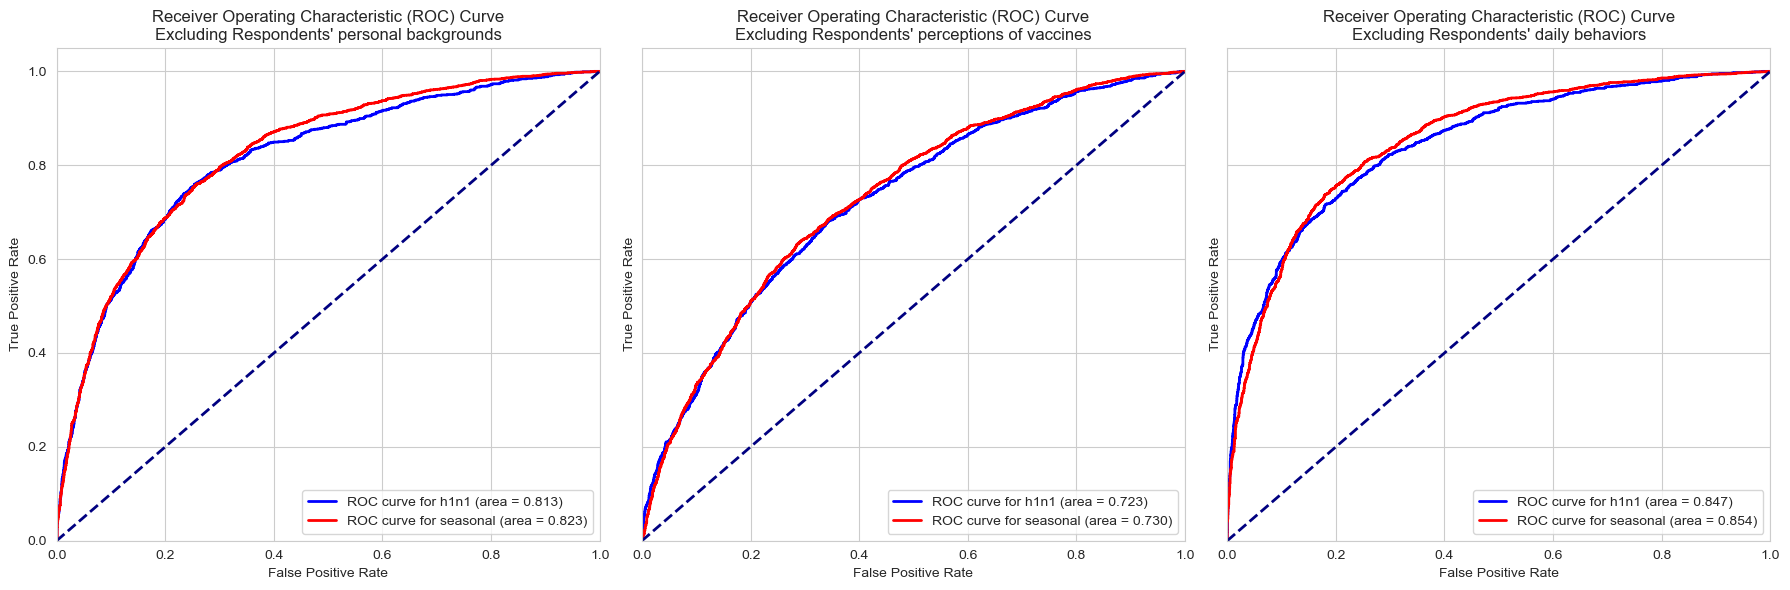

In [17]:
model = PyTorchMLPClassifier()

best_h1n1_model, best_seasonal_model = ablation_experiment(feature_groups, train_features_processed, train_labels, model, 5)

In [18]:
X_test_AE = test_features_processed.drop(daily_behaviors, axis=1)
y_h1n1_predict_AE = best_h1n1_model.predict_proba(X_test_AE)[:,1]
y_seasonal_predict_AE = best_seasonal_model.predict_proba(X_test_AE)[:,1]
results = pd.DataFrame({'respondent_id': test_features['respondent_id'], 'h1n1_vaccine': y_h1n1_predict_AE , 'seasonal_vaccine': y_seasonal_predict_AE})
# Output the result as csv file
results.to_csv('result/predictions_ablation_experiment_yjz.csv', index=False)

AttributeError: 'NoneType' object has no attribute 'eval'